In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.utils import shuffle
import graphviz, pydot

In [3]:
df_rating = pd.read_csv('datasets/rating.csv')
df_rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [4]:
df_rating.userId = pd.Categorical(df_rating.userId)
df_rating['new_user_id'] = df_rating.userId.cat.codes

In [5]:
df_rating.movieId = pd.Categorical(df_rating.movieId)
df_rating['new_movie_id'] = df_rating.movieId.cat.codes

In [6]:
# Get user ID's, movie ID's and rating as separate arrays
user_ids = df_rating.new_movie_id.values
movie_ids = df_rating.new_movie_id.values
ratings = df_rating.rating.values

In [7]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
K = 10

In [8]:
# Make a Neural Network

# User input
u = Input(shape=(1,))
# Movie Input
m = Input(shape=(1,))

# User embedding
# Output is (num_samples, 1, k)
u_emb = Embedding(N, K)(u) 
# Movie embedding
m_emb = Embedding(M, K)(m)

# Flattern both embeddings
# Output is (num_samples, k)
u_emb = Flatten()(u_emb)
m_emb = Flatten()(m_emb)

# Concatenate user-movie embedding into a feature vector
# Output is (num_samples, 2k)
x= Concatenate()([u_emb, m_emb])
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)

In [10]:
# Build the model
model = Model(inputs=[u, m], outputs=x)
model.compile(loss='mse', optimizer='Adam')

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        267440      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 10)        267440      ['input_2[0][0]']                
                                                                                              

In [45]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
# Spliting the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# Center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [16]:
r = model.fit(x=[train_user, train_movie],
              y=train_ratings,
              epochs=25,
              batch_size=1024,
              verbose=2,
              validation_data=([test_user, test_movie], test_ratings))


Epoch 1/25
15626/15626 - 103s - loss: 0.8936 - val_loss: 0.8918 - 103s/epoch - 7ms/step
Epoch 2/25
15626/15626 - 107s - loss: 0.8872 - val_loss: 0.8884 - 107s/epoch - 7ms/step
Epoch 3/25
15626/15626 - 108s - loss: 0.8861 - val_loss: 0.8880 - 108s/epoch - 7ms/step
Epoch 4/25
15626/15626 - 110s - loss: 0.8856 - val_loss: 0.8878 - 110s/epoch - 7ms/step
Epoch 5/25
15626/15626 - 116s - loss: 0.8853 - val_loss: 0.8877 - 116s/epoch - 7ms/step
Epoch 6/25
15626/15626 - 97s - loss: 0.8851 - val_loss: 0.8878 - 97s/epoch - 6ms/step
Epoch 7/25
15626/15626 - 92s - loss: 0.8849 - val_loss: 0.8877 - 92s/epoch - 6ms/step
Epoch 8/25
15626/15626 - 92s - loss: 0.8848 - val_loss: 0.8874 - 92s/epoch - 6ms/step
Epoch 9/25
15626/15626 - 95s - loss: 0.8847 - val_loss: 0.8878 - 95s/epoch - 6ms/step
Epoch 10/25
15626/15626 - 93s - loss: 0.8847 - val_loss: 0.8878 - 93s/epoch - 6ms/step
Epoch 11/25
15626/15626 - 91s - loss: 0.8846 - val_loss: 0.8876 - 91s/epoch - 6ms/step
Epoch 12/25
15626/15626 - 92s - loss: 0.88

In [13]:
loaded_model = tf.keras.models.load_model("./models/recommendation_config_weights")

In [46]:
# Save model & weights
model.save("./models/recommendation_config_weights")

INFO:tensorflow:Assets written to: ./models/recommendation_config_weights\assets


In [35]:
# Save only weights
model.save_weights("./models/recommendation_weights")

In [36]:
# Save only Model
recommendad_json = model.to_json()
with open('./models/recommendation_config.json', 'w') as outfile: 
    outfile.write(recommendad_json) 

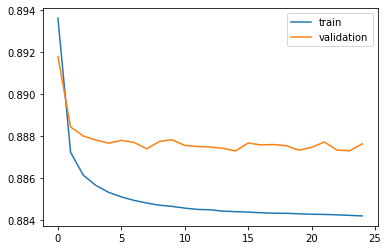

In [40]:
# Plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [21]:
np.sqrt(np.mean(r.history['val_loss']))

0.9422250275231482

In [44]:
r.history.keys()

dict_keys(['loss', 'val_loss'])